
# Baseline Models for News Recommendation

This notebook implements two baseline models for news recommendation using the **MIND dataset**:

1. **Popularity-Based Recommendation**: Recommends the most-clicked news articles overall.
2. **Content-Based Filtering (TF-IDF)**: Recommends news articles similar in text (title + abstract) to a user's previously clicked articles.

In the end, we visualize the most popular news using word maps and charts.


## Merge Click Data with News Metadata

Once we have the click counts, we merge them with the news metadata to retrieve the corresponding news titles, categories, and subcategories.

### Import Libraries
This section imports the necessary libraries for data manipulation, randomization, numerical computations, and visualization using `pandas`, `numpy`, `random`, and `matplotlib`.

In [115]:

import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud


# Load dataset paths
behaviors_file = "../data/raw/MINDsmall_dev/behaviors.tsv"
news_file = "../data/raw/MINDsmall_dev/news.tsv"

# Load behaviors data
behaviors = pd.read_csv(behaviors_file, sep='\t', header=None, names=["Impression ID", "User ID", "Time", "History", "Impressions"])

# Load news data
news = pd.read_csv(news_file, sep='\t', header=None, names=["News ID", "Category", "SubCategory", "Title", "Abstract", "URL", "Title Entities", "Abstract Entities"])


## Popularity Based Recommendation

The table below presents the most clicked news articles along with their categories and subcategories.

### Extract Clicked News IDs
Processes the `Impressions` column to extract the IDs of news articles that were clicked (`-1` suffix). This helps in identifying user interactions with news recommendations.

In [116]:
# Process Impressions column to extract clicked news IDs
clicked_news = []
for impression in behaviors["Impressions"].dropna():
    clicked_news += [item.split("-")[0] for item in impression.split() if item.endswith("-1")]

# Create a DataFrame for clicked news count
clicked_news_df = pd.DataFrame(clicked_news, columns=["News_ID"])
news_click_count = clicked_news_df["News_ID"].value_counts().reset_index()
news_click_count.columns = ["News_ID", "Clicks"]

# Read the news.tsv file
news_cols = ["News_ID", "Category", "SubCategory", "Title", "Abstract", "URL", "Title_Entities", "Abstract_Entities"]
news_df = pd.read_csv(news_file, sep="\t", names=news_cols)

# Merge news click count with news information
news_clicks_merged = news_click_count.merge(news_df[["News_ID", "Title", "Category", "SubCategory"]], on="News_ID")

# Display the table
display(news_clicks_merged.head(10))

,News_ID,Clicks,Title,Category,SubCategory
0,N31958,8042,Opinion: Colin Kaepernick is about to get what...,sports,football_nfl
1,N36779,4688,South Carolina teen gets life in prison for de...,news,newsus
2,N5940,4191,Meghan Markle and Hillary Clinton Secretly Spe...,lifestyle,lifestyleroyals
3,N20036,3826,30 Best Black Friday Deals from Costco,lifestyle,shop-holidays
4,N23513,2900,This was uglier than a brawl. And Myles Garret...,sports,football_nfl
5,N30290,2853,The Real Reason McDonald's Keeps the Filet-O-F...,foodanddrink,restaurantsandnews
6,N58251,2536,"Some believe Mason Rudolph, hit in head with h...",sports,football_nfl
7,N24802,2247,3 Indiana judges suspended after a night of dr...,news,newsus
8,N5472,2135,Report: Police investigating woman's death aft...,sports,football_nfl
9,N53572,1826,"Taylor Swift Rep Hits Back at Big Machine, Cla...",music,musicnews


### Return list of most clicked articles for recommendation


In [117]:

# Count clicks for each news article
news_click_counts = {}

for _, row in behaviors.iterrows():
    if pd.notna(row["Impressions"]):
        for impression in row["Impressions"].split():
            news_id, click = impression.split("-")
            if click == "1":  # Only count clicked articles
                news_click_counts[news_id] = news_click_counts.get(news_id, 0) + 1

# Get the most popular news articles
popular_news = sorted(news_click_counts.items(), key=lambda x: x[1], reverse=True)
top_popular_news = [item[0] for item in popular_news[:10]]  # Top 10 recommended articles

print(top_popular_news)


['N31958', 'N36779', 'N5940', 'N20036', 'N23513', 'N30290', 'N58251', 'N24802', 'N5472', 'N53572']


## Step 4: Generate Recommendations for content based recommendation

### Prepare Text Data and Compute TF-IDF
To create feature representations for the news articles, this section concatenates the title and abstract and then applies TF-IDF vectorization to extract meaningful numerical representations of the text.

In [118]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Function to train TF-IDF and compute similarity scores
def content_based_recommender(user_id, news_df, behaviors_df, news_tfidf, similarity_threshold=0.10, top_n=15):
    # Select user from behaviors data
    sample_user = behaviors_df.iloc[user_id]

    # Extract user's history
    user_history = sample_user["History"].split() if pd.notna(sample_user["History"]) else []
    
    if not user_history:
        print(f"User {user_id} has no history available.")
        return None, None, None

    # Get clicked article indices
    clicked_indices = [news_df.index[news_df["News_ID"] == nid].tolist()[0] 
                       for nid in user_history if nid in news_df["News_ID"].values]

    if not clicked_indices:
        print(f"User {user_id} has no valid clicked articles.")
        return None, None, None

    # **User Profile Creation - Weighted Clicked Articles**
    weights = np.linspace(1.0,1.5, len(clicked_indices))  # More weight to recent clicks
    user_profile = np.average(news_tfidf[clicked_indices].toarray(), axis=0, weights=weights)
    
    # Normalize user profile
    user_profile = user_profile / np.linalg.norm(user_profile)
    user_profile = user_profile.reshape(1, -1)

    # **Compute similarity between user profile and all news articles**
    similarity_scores = cosine_similarity(user_profile, news_tfidf).flatten()

    # Rank articles based on similarity
    ranked_indices = similarity_scores.argsort()[::-1]
    recommended_news = news_df.iloc[ranked_indices]

    # **Filter out clicked articles**
    clicked_articles_set = set(user_history)
    recommended_news = recommended_news[~recommended_news["News_ID"].isin(clicked_articles_set)]
    
    # Assign similarity scores
    filtered_indices = recommended_news.index
    recommended_news = recommended_news.copy()
    recommended_news.loc[:, "Similarity"] = similarity_scores[filtered_indices]
    
    # Apply similarity threshold
    recommended_news = recommended_news[recommended_news["Similarity"] > similarity_threshold]

    # **Ensure Diversity - Select Top 3 per Category**
    recommended_news = recommended_news.groupby("Category").head(3)
    recommended_news = recommended_news.head(top_n)

    # **Merge with Clicks Count & Sort**
    recommended_news = recommended_news.merge(news_clicks_merged[["News_ID", "Clicks"]], 
                                              on="News_ID", how="left").fillna(0)
    recommended_news = recommended_news.sort_values(by=["Similarity", "Clicks"], ascending=[False, False])

    # Extract similarity scores for evaluation
    clicked_similarities = similarity_scores[clicked_indices]
    recommended_similarities = recommended_news["Similarity"].values

    return recommended_news, clicked_similarities, recommended_similarities


### User History Overview


,News_ID,Title,Category,SubCategory
3022,N28467,Four-metre king cobra wrestled from sewer in T...,news,newsworld
4203,N49008,Bengals' Andy Dalton was looking to be traded ...,sports,football_nfl
4746,N63709,18th-century shipwreck discovered after 40-yea...,video,science
6670,N41089,This Man's Rattlesnake Bite Is a Warning to Ev...,lifestyle,lifestylebuzz
7498,N55189,"'Wheel Of Fortune' Guest Delivers Hilarious, O...",tv,tvnews
7555,N57318,"A 2,000-pound great white shark is swimming of...",news,newsus
7925,N29599,Falcons cut franchise mainstay Matt Bryant,sports,football_nfl
8281,N55743,17 photos that show the ugly truth of living i...,lifestyle,lifestylehomeandgarden
8587,N62383,Panthers Wire bye week awards: 2019 standouts ...,sports,football_nfl
8892,N46082,Archaeologists open ancient coffins in Egypt,video,science



### Content-Based Recommendations


,News_ID,Title,Category,SubCategory,Similarity
0,N46927,Panthers coach Ron Rivera won't pressure QB Ca...,sports,football_nfl,0.390974
1,N7310,Carolina Panthers place Cam Newton on injured ...,sports,more_sports,0.361928
2,N2435,Should quarterback Kyle Allen keep the Carolin...,sports,football_nfl_videos,0.361734
3,N52907,A 533-pound Great White Shark Has Been Tracked...,news,newsus,0.129991
4,N19418,Carolina Panthers' Christian McCaffrey doesn't...,finance,financenews,0.117126
5,N34000,Wayne Newton's house burglar sentenced to 22 y...,music,music-celebrity,0.107165
6,N9743,Shark swims on its back,video,animals,0.106887
7,N47329,'Is that normal?': Tourists catch rare glimpse...,video,animals,0.106666
8,N45193,"If Not Peter Luger, Who Serves NYC's Best Steak?",foodanddrink,foodnews,0.106459
9,N21688,"Missing boaters, dog from New England found sa...",news,newsus,0.099651


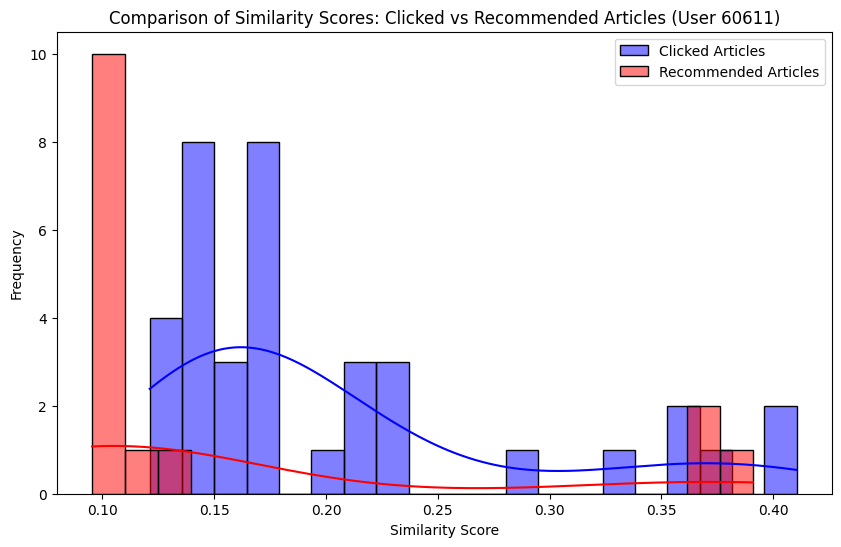

In [124]:
# Prepare text data for content-based filtering
news["Text"] = news["Title"].fillna("") + " " + news["Abstract"].fillna("")

# **Train TF-IDF Vectorizer**
vectorizer = TfidfVectorizer(stop_words='english', max_features=30000)
news_tfidf = vectorizer.fit_transform(news["Text"])

# **Select User and Generate Recommendations**
random_index = random.randint(0, len(behaviors) - 1)
user_id = random_index  # Change this to test different users
recommended_news, clicked_similarities, recommended_similarities = content_based_recommender(
    user_id=user_id, news_df=news_df, behaviors_df=behaviors, 
    news_tfidf=news_tfidf, similarity_threshold=0.08, top_n=15
)

# **Plot Results**
if recommended_news is not None:
    print("\n### User History Overview")
    display(news_df[news_df["News_ID"].isin(behaviors.iloc[user_id]["History"].split())][["News_ID", "Title", "Category", "SubCategory"]])

    print("\n### Content-Based Recommendations")
    display(recommended_news[["News_ID", "Title", "Category", "SubCategory", "Similarity"]])

    plt.figure(figsize=(10, 6))
    sns.histplot(clicked_similarities, bins=20, label="Clicked Articles", color="blue", kde=True)
    sns.histplot(recommended_similarities, bins=20, label="Recommended Articles", color="red", kde=True)
    plt.xlabel("Similarity Score")
    plt.ylabel("Frequency")
    plt.title(f"Comparison of Similarity Scores: Clicked vs Recommended Articles (User {user_id})")
    plt.legend()
    plt.show()


## Visualization of News

### Generate Word Cloud Visualization
A word cloud is created using the `wordcloud` library to visualize the most frequently occurring categories in the dataset. This helps in understanding the distribution of news topics.

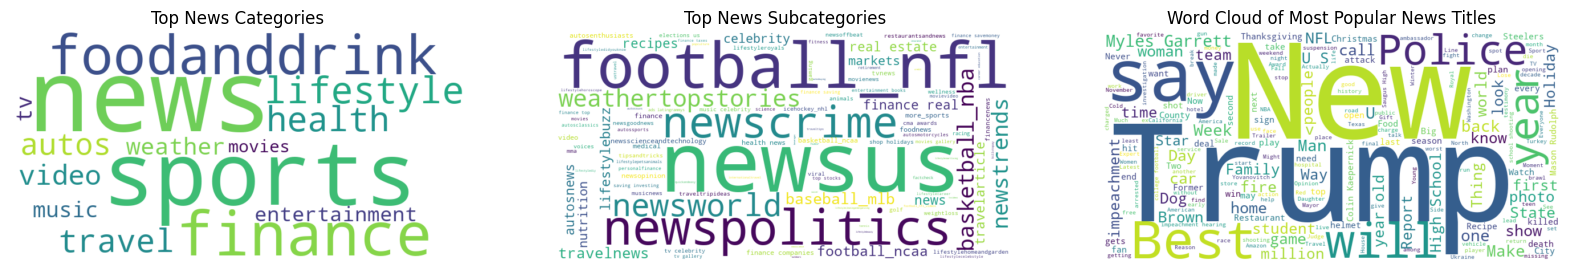

In [120]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Generate word cloud text data
text_categories = " ".join(news_clicks_merged["Category"].dropna())
text_subcategories = " ".join(news_clicks_merged["SubCategory"].dropna())
wordcloud_text = " ".join(news_clicks_merged["Title"].dropna())

# Create a single figure with three subplots for word clouds
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

# Word cloud for categories
wordcloud_categories = WordCloud(width=800, height=400, background_color="white").generate(text_categories)
axes[0].imshow(wordcloud_categories, interpolation="bilinear")
axes[0].axis("off")
axes[0].set_title("Top News Categories")

# Word cloud for subcategories
wordcloud_subcategories = WordCloud(width=800, height=400, background_color="white").generate(text_subcategories)
axes[1].imshow(wordcloud_subcategories, interpolation="bilinear")
axes[1].axis("off")
axes[1].set_title("Top News Subcategories")

# Word Cloud of Popular News Titles
wordcloud_titles = WordCloud(width=800, height=400, background_color='white').generate(wordcloud_text)
axes[2].imshow(wordcloud_titles, interpolation="bilinear")
axes[2].axis("off")
axes[2].set_title("Word Cloud of Most Popular News Titles")

# Show the combined plot
plt.show()

